In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, norm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from hmmlearn import hmm

# Importing Data
### Formatting to Date & Extracting months

In [2]:
df = pd.read_csv('Tehran 2009-2019.csv', encoding='latin1')

In [3]:
df['Date'] = pd.to_datetime(df['Year'], format='%m/%d/%y')

In [4]:
df['Rain'] = df['Rain'].str.replace(' mm', '').astype(float)

In [5]:
df = df[df['Rain'] > 0]

In [6]:
df['YearMonth'] = df['Date'].dt.to_period('M')

# Monthly SPI
### Data Cleaning & Transition Matrix

In [7]:
monthly_rainfall = df.groupby('YearMonth').agg({
    'Rain' :'sum'
})
monthly_rainfall = monthly_rainfall.reset_index()
monthly_rainfall['YearMonth'] = monthly_rainfall['YearMonth'].astype(str)
monthly_rainfall['YearMonth'] = pd.to_datetime(monthly_rainfall['YearMonth'])

In [8]:
shape, loc, scale = gamma.fit(monthly_rainfall['Rain'], floc=0)

In [9]:
monthly_rainfall['CDF'] = gamma.cdf(monthly_rainfall['Rain'], shape, loc, scale)

In [10]:
monthly_rainfall['SPI'] = norm.ppf(monthly_rainfall['CDF'])

In [11]:
filt = monthly_rainfall['SPI'] == 0
monthly_rainfall[filt]

,YearMonth,Rain,CDF,SPI


In [12]:
l = list()
for i in monthly_rainfall['SPI']:
    if i < 0:
        l.append(0)
    else:
        l.append(1)

monthly_rainfall['SPI_bin'] = l

In [13]:
monthly_rainfall['SPI_bin'].value_counts()

SPI_bin
0    75
1    67
Name: count, dtype: int64

In [14]:
def transition_matrix(df, col_name):
    p00 = 0
    p11 = 0
    states = df[col_name].unique()
    for i in range(len(df)-1):
        if df.loc[i,col_name] == states[0] and df.loc[i+1,col_name] == states[0]:
            p00 += 1/(df.loc[:len(df)-2,col_name].value_counts()[0])
        elif df.loc[i,col_name] == states[1] and df.loc[i+1,col_name] == states[1]:
            p11 += 1/(df.loc[:len(df)-2,col_name].value_counts()[1])
        elif i == len(df):
            pass

    p01 = 1-p00
    p10 = 1- p11
    

    transition_matrix = np.array ([[p00,p01],
                                  [p10,p11]])
    
    return transition_matrix 

In [15]:
A = transition_matrix(monthly_rainfall, 'SPI_bin')
A

array([[0.66666667, 0.33333333],
       [0.36363636, 0.63636364]])

In [16]:
A2 = np.dot(A, A)
A3 = np.dot(A2, A)
A4 = np.dot(A3, A)
A5 = np.dot(A4, A)
A2, A3, A4, A5

(array([[0.56565657, 0.43434343],
        [0.4738292 , 0.5261708 ]]),
 array([[0.53504744, 0.46495256],
        [0.50722097, 0.49277903]]),
 array([[0.52577195, 0.47422805],
        [0.51733969, 0.48266031]]),
 array([[0.5229612 , 0.4770388 ],
        [0.52040597, 0.47959403]]))

## Hold-out testing
Spliting the data, fist half for fitting, other half for testing

In [17]:
len(monthly_rainfall)

142

In [18]:
df1 = monthly_rainfall.iloc[:71]
df2 = monthly_rainfall.iloc[71:]

In [19]:
l = list()
for i in df1['SPI_bin'].value_counts():
    l.append(i/71)
l = np.array(l)
l

array([0.63380282, 0.36619718])

In [20]:
def prediction(initial_vector, df,transition_matrix):
    B = np.array(initial_vector)
    for _ in range(len(df)-1):
        B = np.dot(B,transition_matrix)
    return B

In [21]:
p = list(prediction(l,df1,A))
predict = list()
for x in p:
    predict.append(x*71)
predict

[37.043478260869556, 33.95652173913045]

In [22]:
observed = list()
for i in df2['SPI_bin'].value_counts():
    observed.append(i)
observed

[41, 30]

# Annual SPI 
### Data cleaning & Transition Matrix

In [23]:
df['Year'] = pd.to_datetime(df['Date']).dt.year
yearly_data = df.groupby('Year')['Rain'].sum().reset_index()

In [24]:
shape, loc, scale = gamma.fit(yearly_data['Rain'], floc=0)

In [25]:
yearly_data['CDF'] = gamma.cdf(yearly_data['Rain'], shape, loc, scale)

In [26]:
yearly_data['SPI'] = norm.ppf(yearly_data['CDF'])

In [27]:
l = list()
for i in yearly_data['SPI']:
    if i < 0:
        l.append(0)
    else:
        l.append(1)

yearly_data['SPI_bin'] = l

In [28]:
A = transition_matrix(yearly_data, 'SPI_bin')

In [29]:
A2 = np.dot(A, A)
A3 = np.dot(A2, A)
A4 = np.dot(A3, A)
A5 = np.dot(A4, A)
A2, A3, A4, A5

(array([[0.54081633, 0.45918367],
        [0.53571429, 0.46428571]]),
 array([[0.53862974, 0.46137026],
        [0.53826531, 0.46173469]]),
 array([[0.53847355, 0.46152645],
        [0.53844752, 0.46155248]]),
 array([[0.5384624 , 0.4615376 ],
        [0.53846054, 0.46153946]]))

In [30]:
prediction([1,0],yearly_data,A)

array([0.53846154, 0.46153846])

# Monthly Rain
### Data Cleaning & Transition Matrix

In [31]:
monthly_rainfall['Rain'].describe()

count    142.000000
mean      20.909155
std       23.625893
min        0.100000
25%        6.525000
50%       13.800000
75%       26.675000
max      164.300000
Name: Rain, dtype: float64

In [32]:
l = list()
for x in monthly_rainfall['Rain']:
    if x < monthly_rainfall['Rain'].mean():
        l.append(0)
    else:
        l.append(1)
monthly_rainfall['Rain_bin'] = l
monthly_rainfall.drop(['CDF','SPI','SPI_bin'],axis=1,inplace = True)
monthly_rainfall.head()

,YearMonth,Rain,Rain_bin
0,2009-01-01,10.0,0
1,2009-02-01,9.9,0
2,2009-03-01,3.2,0
3,2009-04-01,33.1,1
4,2009-05-01,13.8,0


In [33]:
A = transition_matrix(monthly_rainfall, 'Rain_bin')
A

array([[0.75      , 0.25      ],
       [0.39622642, 0.60377358]])

# Annual Rain 
### Data cleaning & Transition Matrix

In [34]:
l = list()
for x in yearly_data['Rain']:
    if x < yearly_data['Rain'].mean():
        l.append(0)
    else:
        l.append(1)
yearly_data['Rain_bin'] = l
yearly_data.drop(['CDF','SPI','SPI_bin'],axis=1,inplace = True)
yearly_data.head()

,Year,Rain,Rain_bin
0,2009,131.6,0
1,2010,125.7,0
2,2011,212.6,0
3,2012,242.5,0
4,2013,118.4,0


In [35]:
A = transition_matrix(yearly_data, 'Rain_bin')
A

array([[0.75      , 0.25      ],
       [0.33333333, 0.66666667]])

# ARIMA Time-series Model
### Modelling Rain continiously, without conversion to Binary
Slicing the dataframe to two train & test data frames

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142 entries, 2009-01-01 to 2020-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rain    142 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


<Axes: xlabel='YearMonth'>

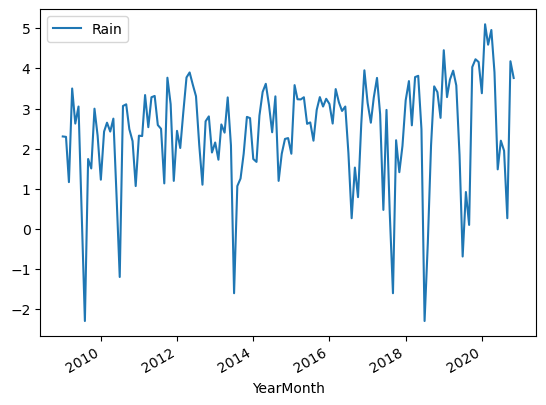

In [36]:
monthly_rainfall.drop('Rain_bin',axis=1,inplace=True)
monthly_rainfall = monthly_rainfall.set_index('YearMonth')
monthly_rainfall = np.log(monthly_rainfall)
monthly_rainfall.info()
monthly_rainfall.plot()

In [37]:
df_train = monthly_rainfall.iloc[0:71]
df_test = monthly_rainfall.iloc[71:]

### Step 1:
check for the stationary of time series
### ACF & PACF plot


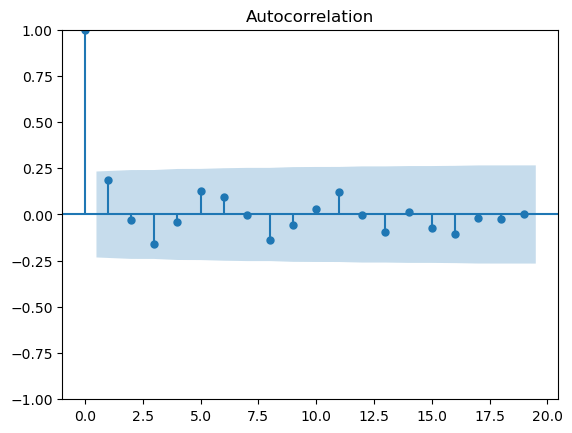

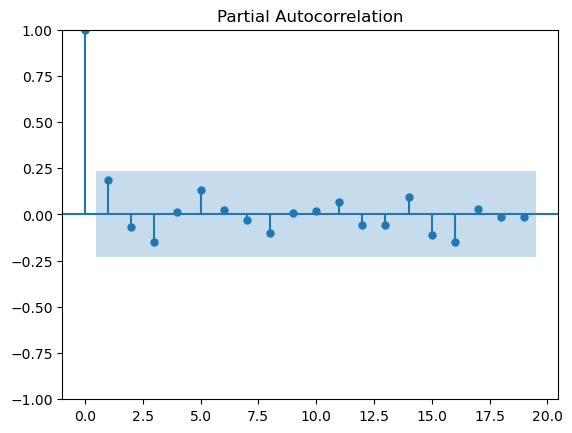

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

### ADF test
null hypothesis (H0): there is a unique root (non-stationary)

In [39]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 1.792639715239262e-09


### Step 2:
Determine ARIMA models parameters p, q & 
### Fit the ARIMA model

In [40]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Rain   No. Observations:                   71
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -118.655
Date:                Sat, 20 Jul 2024   AIC                            243.310
Time:                        15:05:19   BIC                            250.055
Sample:                             0   HQIC                           245.989
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4430      0.107     -4.141      0.000      -0.653      -0.233
ar.L2         -0.2124      0.118     -1.800      0.072      -0.444       0.019
sigma2         1.7313      0.178      9.724      0.0

C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


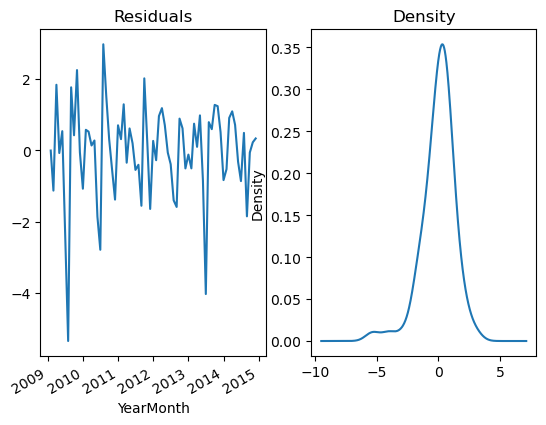

In [41]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

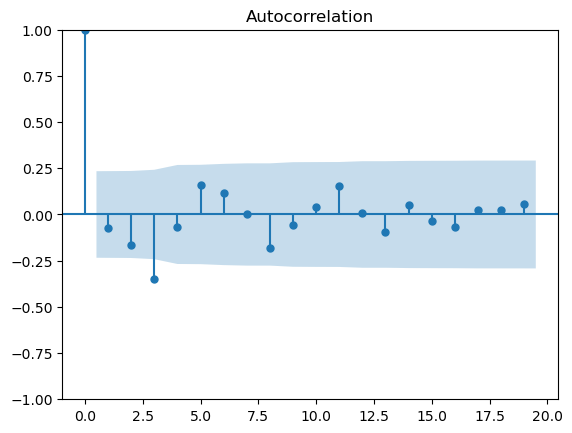

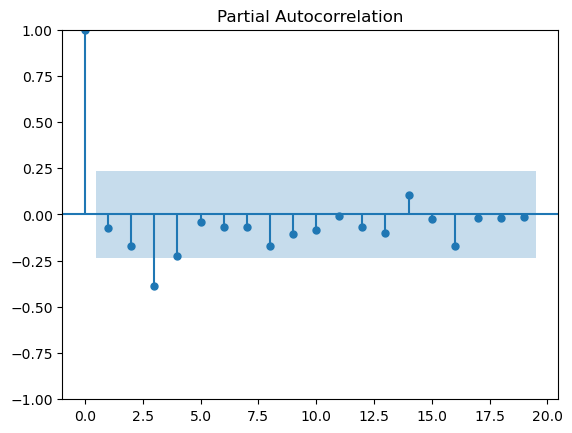

In [42]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

In [43]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [44]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   71
Model:               SARIMAX(5, 0, 0)   Log Likelihood                -113.355
Date:                Sat, 20 Jul 2024   AIC                            238.710
Time:                        15:05:23   BIC                            252.286
Sample:                             0   HQIC                           244.108
                                 - 71                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3775      0.119      3.179      0.001       0.145       0.610
ar.L2          0.1409      0.192      0.734      0.463      -0.235       0.517
ar.L3         -0.0133      0.165     -0.081      0.936      -0.336       0.310
ar.L4          0.1378      0.159      0.864      0.387      -0.175       0.450
ar.L5          0.3103      0.160      1.945      0.052      -0.002       0.623
sigma2         1.3805      0.210      6.583      0.000       0.970       1.792
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                81.19
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -1.63
Prob(H) (two-sided):                  0.18   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Step 3:
Make time series predictions

C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='YearMonth'>

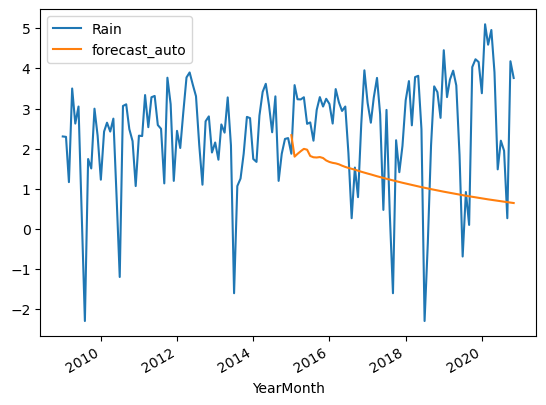

In [45]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
monthly_rainfall['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)
monthly_rainfall.plot()

C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='YearMonth'>

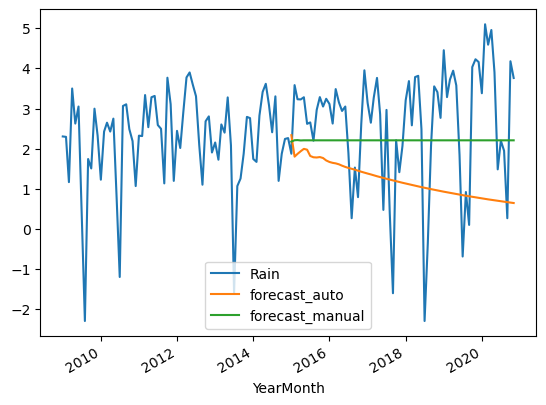

In [46]:
forecast_test = model_fit.forecast(len(df_test))

monthly_rainfall['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

monthly_rainfall.plot()

# HMM model
Data cleaning, Fitting HMM model, presenting the transition matrix & each hidden state influence on rain

In [47]:
df = pd.read_csv('Tehran 2009-2019.csv', encoding='latin1')
df['Max'] = df['Max'].str.replace(' °c', '').astype(float)
df['Min'] = df['Min'].str.replace(' °c', '').astype(float)
df['Wind'] = df['Wind'].str.extract('(\d+)').astype(float)
df['Rain'] = df['Rain'].str.replace(' mm', '').astype(float)
df['Humidity'] = df['Humidity'].str.replace('%', '').astype(float)
df['Cloud'] = df['Cloud'].str.replace('%', '').astype(float)
df['Pressure'] = df['Pressure'].str.replace(' mb', '').astype(float)
df['Date'] = pd.to_datetime(df['Year'], format='%m/%d/%y')
df.head()

,Year,Weather,Max,Min,Wind,Rain,Humidity,Cloud,Pressure,Date
0,1/1/09,Partly cloudy,5.0,-5.0,4.0,0.0,62.0,26.0,1022.0,2009-01-01
1,1/2/09,Sunny,4.0,0.0,5.0,3.4,74.0,32.0,1014.0,2009-01-02
2,1/3/09,Sunny,4.0,-3.0,12.0,0.0,60.0,6.0,1016.0,2009-01-03
3,1/4/09,Sunny,3.0,-7.0,9.0,0.0,35.0,1.0,1022.0,2009-01-04
4,1/5/09,Sunny,4.0,-7.0,3.0,0.0,23.0,14.0,1023.0,2009-01-05


In [48]:
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df.select_dtypes(include=[np.number]))
label_encoders = {}
for column in df.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)
target = df['Rain'].values
features = data_scaled
n_components = 2  # این مقدار می‌تواند بر اساس مسئله تنظیم شود
hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=1000)


hmm_model.fit(features)
hidden_states = hmm_model.predict(features)
print("transition matrix")
print(hmm_model.transmat_)


transition matrix
[[0.95093311 0.04906689]
 [0.0398918  0.9601082 ]]


In [49]:
for i in range(n_components):
    print(f" Hidden State {i}th")
    print("mean =", hmm_model.means_[i])
    print("var =", np.diag(hmm_model.covars_[i]))

df['Hidden_State'] = hidden_states

rain_influence = df.groupby('Hidden_State')['Rain'].mean()
print("Hidden state influences on'Rain':")
print(rain_influence)


columns_to_analyze = ['Max', 'Min', 'Wind', 'Humidity', 'Cloud', 'Pressure']
for column in columns_to_analyze:
    influence = df.groupby('Hidden_State')[column].mean()
    print(f"'{column}'Hidden state influences on ")
    print(influence)


 Hidden State 0th
mean = [ 0.93339139  0.90569171  0.21925848 -0.20007595 -0.80758487 -0.44561741
 -0.66985249]
var = [0.20090808 0.2261326  0.8487077  0.033684   0.2354768  0.27522101
 0.44501102]
 Hidden State 1th
mean = [-0.75853766 -0.73602701 -0.17818443  0.1625954   0.65629868  0.36213917
  0.54436794]
var = [0.3660132  0.42055661 1.0521407  1.72633412 0.66056734 1.29649303
 0.79004769]
Hidden state influences on'Rain':
Hidden_State
0    0.207708
1    1.074529
Name: Rain, dtype: float64
'Max'Hidden state influences on 
Hidden_State
0    29.543165
1    11.519899
Name: Max, dtype: float64
'Min'Hidden state influences on 
Hidden_State
0    19.891572
1     3.471722
Name: Min, dtype: float64
'Wind'Hidden state influences on 
Hidden_State
0    8.308839
1    6.997486
Name: Wind, dtype: float64
'Humidity'Hidden state influences on 
Hidden_State
0    21.491264
1    46.018433
Name: Humidity, dtype: float64
'Cloud'Hidden state influences on 
Hidden_State
0     6.250257
1    19.401341
Name: 